In [1]:
import itk
import imagej
import time
import numpy as np

In [2]:
def get_java_dependencies():
    """
    Returns the jar files that need to be included into the classpath
    of an imagej object in order to have a functional ABBA app
    these jars should be available in https://maven.scijava.org/
    :return:
    """
    imagej_core_dep = 'net.imagej:imagej:2.9.0'
    imagej_legacy_dep = 'net.imagej:imagej-legacy:0.39.2'
    abba_dep = 'ch.epfl.biop:ImageToAtlasRegister:0.3.6'
    return [imagej_core_dep, imagej_legacy_dep, abba_dep]

In [3]:
ij = imagej.init(get_java_dependencies(), mode='interactive')
ij.ui().showUI()  # required I fear

In [4]:
from scyjava import jimport
from jpype import JImplements, JOverride
from jpype.types import JString, JBoolean, JDouble, JInt



In [5]:

ExternalABBARegistrationPlugin = jimport('ch.epfl.biop.atlas.aligner.plugin.ExternalABBARegistrationPlugin')
AffineTransform3D = jimport('net.imglib2.realtransform.AffineTransform3D')
MultiSlicePositioner = jimport('ch.epfl.biop.atlas.aligner.MultiSlicePositioner')

Supplier = jimport('java.util.function.Supplier')

Command = jimport('org.scijava.command.Command')
JPlugin = jimport('org.scijava.plugin.Plugin')
Parameter = jimport('org.scijava.plugin.Parameter')
ImagePlus = jimport('ij.ImagePlus')

In [6]:
#org.scijava.command.PyCommandBuilder
PyCommandBuilder = jimport('org.scijava.command.PyCommandBuilder')

# Decorator that registers a python CLASS containing a method named "run" as a scijava Command
#
# This uses PyCommandBuilder which is in the java repo ch.epfl.biop:pyimagej-scijava-command:0.1.0-SNAPSHOT
# PyCommandBuilder allows to build a Command fully programmatically without using any
# java annotation as java annotations are needed for 'easy' Scijavy Commands definition
# but these are not completely supported in JPype: 
# cf https://github.com/jpype-project/jpype/issues/940
# 
# See cell below for example usage
#
# Note: this way of defining a command is probably not ideal if this has to be used from the python side also
#
# Because it's a preliminary work, this decorator prints a lot of stuff in the process
#
# TODO: functools ?? NOt sure it's necessary

def ScijavaCommand(**kwargs):    
    
    print("- Registering scijava command "+kwargs['name'])
    
    def registerCommand(func): 
        # This class will be registered as a SciJava Command
        builder = PyCommandBuilder() # Java PyCommandBuilder
        
        # The name of the command - to avoid name conflicts, consider a 'virtual' class name with its package
        builder = builder.name(kwargs['name'])
        
        # Register all inputs
        print('- Inputs')
        for name, javaClass in kwargs['inputs'].items():
            print('\t', name,' : ', javaClass)
            builder = builder.input(name, javaClass)
            setattr(func, name, None) # declares empty input field 
        print('Inputs registered')
        
        # Register all outputs
        print('- Outputs')
        for name, javaClass in kwargs['outputs'].items():
            print('\t', name,' : ', javaClass)
            builder = builder.output(name, javaClass)
            setattr(func, name, None) # declares empty output field
        print('Outputs registered')
                
        # Wraps the run function - takes kwargs as input, returns outputs
        def wrapped_run(inner_kwargs):
            inner_object = func()
            print('Settings inputs...')
            print(inner_kwargs)
            for name, javaClass in kwargs['inputs'].items():
                #print(name)
                #print(str(inner_kwargs[name]))
                setattr(inner_object, name, inner_kwargs[name]) # sets inputs 
            print('Inputs set.')
            print('Running scijava command: '+kwargs['name'])
            inner_object.run() #I'm not sure this actually works
            print(kwargs['name']+' command execution done.')
            print('Fetching outputs...')
            outputs = {}
            for name, javaClass in kwargs['outputs'].items():
                outputs[name] = getattr(inner_object, name) # gets outputs
            print('Outputs set.')
            return JObject(outputs, JClass('java.util.Map')) # Returns output as a java HashMap
        
        # Sets the function in PyCommandBuilder:
        # Function<Map<String, Object>, Map<String, Object>> command
        builder = builder.function(wrapped_run)
        
        # Effectively registers this command to the ij context
        builder.create(kwargs['context']) 
        return func
    
    return registerCommand

In [ ]:
# Example of registering a Scijava Command via the @ScijavaCommand decorator

@ScijavaCommand(context = ij.context(), # ij context needed
                name = 'pyCommand.HelloCommand', # name of this command, mind potential naming conflicts!
                inputs = {'name': JString, 'familiar': JBoolean}, # input name, input Java class, as dictionary
                outputs = {'greetings': JString}) # output name, output Java class, as dictionary
class MyPyCommand:        
    def run(self):
        if (self.familiar):
            self.greetings = 'Hi ' + str(self.name) + '!'
        else:
            self.greetings = 'Hello my dear ' + str(self.name) + '.'
            

In [ ]:
@JImplements(ExternalABBARegistrationPlugin)
class ItkAffineRegistration(object):
    
    #Map<String, String> params = new HashMap<>();
    #SourceAndConverter<?>[] fimg;
    #SourceAndConverter<?>[] mimg;
    #protected boolean isDone = false;
    #int timepoint = 0;
    
    def __init__(self):
        self.timepoint = 0
        self.isDone = False
    
    @JOverride
    def getMap(self):
        return self.bg_atlasmap

    @JOverride
    def getRegistrationTypeName(self):
        return JString("ItkAffineRegistration")

    @JOverride
    def setSliceInfo(self, sliceInfo):
        pass

    @JOverride
    def isManual(self):
        return False;

    @JOverride
    def isEditable(self):
        return False

    @JOverride
    def  userInterface(self):
        return None #new Class[0]; #Class<? extends Command>[]

    @JOverride
    def setScijavaContext(self, context):
        self.context = context
    
    @JOverride
    def setRegistrationParameters(self, parameters):
        self.params = parameters

    @JOverride
    def getRegistrationParameters(self):
        return self.params

    @JOverride
    def setFixedImage(self, fimg):
        self.fimg = fimg
        
    @JOverride
    def setMovingImage(self, mimg):
        self.mimg = mimg
        
    @JOverride
    def setFixedMask(self, fimg_mask):
        self.fimg_mask = fimg_mask
        
    @JOverride
    def setMovingMask(self, mimg_mask):
        self.mimg = mimg_mask
   
    @JOverride
    def resetRegistration(self):
        self.isDone = False
        
    @JOverride
    def resetRegistration(self):
        self.isDone = False
        
    @JOverride
    def setTimePoint(timepoint):
        self.timepoint = timePoint


    @JOverride
    def register(self):
        print("Registering...")
        time.sleep(3)
        print("Done")
        self.isDone = True
        return True

    @JOverride
    def edit(self):
        raise Exception("Unsupported","ItkAffineRegistration registration plugin is not editable")

    @JOverride
    def isRegistrationDone(self):
        return self.isDone

    @JOverride
    def getTransformedImageMovingToFixed(self, img):
        return img; # SourceAndConverter<?>[]

    @JOverride
    def getTransformedPtsFixedToMoving(self, pts):
        return pts #RealPointList

    @JOverride
    def abort(self):
        pass 

    @JOverride
    def getTransform(self):
        return ""

    @JOverride
    def setTransform(self, serialized_transform):
        self.isDone = True

    @JOverride
    def getTransformAsRealTransform():
        return AffineTransform3D()
    
@JImplements(Supplier)
class ItkAffineRegistrationSupplier(object):
    
    @JOverride
    def get(self):
        return ItkAffineRegistration()
    
MultiSlicePositioner.registerRegistrationPlugin('ItkAffineRegistration', ItkAffineRegistrationSupplier())

In [7]:
SimpleABBARegistrationPlugin = jimport('ch.epfl.biop.atlas.aligner.plugin.SimpleABBARegistrationPlugin')

@JImplements(SimpleABBARegistrationPlugin)
class SimpleRotateAffineRegistration(object):
    
    def __init__(self):
        print('init SimpleRotateAffineRegistration')
        pass
    
    # @return Sampling required for the registration, in micrometer (double)
    #
    @JOverride
    def getVoxelSizeInMicron(self):
        return JDouble(40)

    
    # Is called before registration to pass any extra registration parameter
    # argument. Passed as a dictionary of String to preserve serialization
    # capability.
    # param parameters dictionary of parameters (Map<String, String>)
    @JOverride
    def setRegistrationParameters(self, parameters):
        self.parameters = parameters

    # param fixed image (ImagePlus)
    # param moving image (ImagePlus)
    # param fixed mask (ImagePlus)
    # param moving mask (ImagePlus)
    # return the transform, result of the registration, (InvertibleRealTransform)
    # going from fixed to moving coordinates, in pixels
    @JOverride
    def register(self, fixed, moving, fixedMask, movingMask):
        #fixed.show()
        #moving.show()
        ij.py.show(fixed)
        ij.py.show(moving)
        print('0')
        transform = AffineTransform3D()
        print('1')
        #transform.translate(50,50,0);
        #transform.rotate(2,1);
        
        print('2')
        global parameter_object 
        parameter_object = itk.ParameterObject.New()
        print('3')
        default_rigid_parameter_map = parameter_object.GetDefaultParameterMap('rigid')
        
        print('4')
        parameter_object.AddParameterMap(default_rigid_parameter_map)
        
        global fixed_py
        global moving_py
        print('4a')
        fixed_py = ij.py.from_java(fixed)
        
        print('4b')
        moving_py = ij.py.from_java(moving)
        
        print(str(type(fixed_py)))
        print(str(type(moving_py)))
        
        print('5')
        
        print('5a')
        fixed_py = fixed_py.to_numpy().astype(np.float32)
        
        print('5b')
        moving_py = moving_py.to_numpy().astype(np.float32)
        
        print('6')
        
        print(str(type(fixed_py)))
        print(str(type(moving_py)))
        
        print('6a')
        
        # Call registration function
        result_image, result_transform_parameters = itk.elastix_registration_method(
            fixed_py, moving_py,
            parameter_object=parameter_object,
            log_to_console=True)
        
        print('7')
        ij.py.show(result_image)
        
        print('8')
        return transform
    
SimpleRegistrationWrapper = jimport('ch.epfl.biop.atlas.aligner.plugin.SimpleRegistrationWrapper')
    
@JImplements(Supplier)
class SimpleRotateAffineRegistrationSupplier(object):
    
    @JOverride
    def get(self):
        return SimpleRegistrationWrapper(JString('SimpleRotateAffineRegistration'), SimpleRotateAffineRegistration())
    
MultiSlicePositioner.registerRegistrationPlugin('SimpleRotateAffineRegistration', SimpleRotateAffineRegistrationSupplier())



- Registering scijava command abba.SimpleRotateAffineRegistration
- Inputs
	 fixed_channel  :  <java class 'JInt'>
	 moving_channel  :  <java class 'JInt'>
	 mp  :  <java class 'ch.epfl.biop.atlas.aligner.MultiSlicePositioner'>
Inputs registered
- Outputs
Outputs registered


[java.lang.Enum.toString] 17:31:54.866 [SciJava-6e106680-Thread-2] DEBUG sc.fiji.bdvpg.scijava.services.SourceAndConverterService - Plugin found for entity class Displaysettings
[java.lang.Enum.toString] 17:31:55.086 [SciJava-6e106680-Thread-2] INFO sc.fiji.bdvpg.scijava.services.SourceAndConverterService - Spimdata mpicbg.spim.data.SpimData@6ccba82 is using the Bdv Playground global cache.
[java.lang.Enum.toString] [WARNING] Ignoring unsupported output: ba [ch.epfl.biop.atlas.mouse.allen.ccfv3.command.AllenBrainAdultMouseAtlasCCF2017Command]
[java.lang.Enum.toString] [WARNING] Ignoring unsupported output: atlas [ch.epfl.biop.atlas.mouse.allen.ccfv3.command.AllenBrainAdultMouseAtlasCCF2017Command]
[java.lang.Enum.toString] 17:31:56.566 [SciJava-6e106680-Thread-3] DEBUG ch.epfl.biop.atlas.aligner.ReslicedAtlas - index = 0| source key: Nissl
[java.lang.Enum.toString] 17:31:56.566 [SciJava-6e106680-Thread-3] DEBUG ch.epfl.biop.atlas.aligner.ReslicedAtlas - NISSL
[java.lang.Enum.toString] 

[java.lang.Enum.toString] 17:31:56.791 [SciJava-6e106680-Thread-3] DEBUG bdv.util.ResampledSource - Model mipmap level 0 has a characteristic voxel size of 0.01
[java.lang.Enum.toString] 17:31:56.796 [SciJava-6e106680-Thread-3] DEBUG bdv.util.ResampledSource - Origin level 0 has a characteristic voxel size of 0.01
[java.lang.Enum.toString] 17:31:56.796 [SciJava-6e106680-Thread-3] DEBUG bdv.util.ResampledSource - Model mipmap level 1 correspond to origin mipmap level 2
[java.lang.Enum.toString] 17:31:56.796 [SciJava-6e106680-Thread-3] DEBUG bdv.util.ResampledSource - Model mipmap level 1 has a characteristic voxel size of 0.02001526717557252
[java.lang.Enum.toString] 17:31:56.796 [SciJava-6e106680-Thread-3] DEBUG bdv.util.ResampledSource - Origin level 2 has a characteristic voxel size of 0.04
[java.lang.Enum.toString] 17:31:56.806 [SciJava-6e106680-Thread-3] DEBUG bdv.util.ResampledSource - Model mipmap level 2 correspond to origin mipmap level 3
[java.lang.Enum.toString] 17:31:56.806 

[java.lang.Enum.toString] 17:31:58.616 [SciJava-6e106680-Thread-6] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Installing behaviours : common
[java.lang.Enum.toString] 17:31:58.623 [SciJava-6e106680-Thread-6] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Installing behaviours : positioning
[java.lang.Enum.toString] 17:31:58.623 [SciJava-6e106680-Thread-6] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Installing behaviours : review
[java.lang.Enum.toString] 17:31:58.629 [SciJava-6e106680-Thread-6] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Refresh Block Map called
[java.lang.Enum.toString] 17:31:58.635 [SciJava-6e106680-Thread-6] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Overriding standard navigation commands
[java.lang.Enum.toString] 17:31:58.635 [SciJava-6e106680-Thread-6] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Refresh Block Map called
[java.lang.Enum.toString] 17:31:58.635 [SciJava-6e106680-Thread-6] DEBUG c

[java.lang.Enum.toString] 17:32:04.347 [SciJava-6e106680-Thread-4] DEBUG org.scijava.nativelib.BaseJniExtractor - Deleting leftover folder: C:\Users\nicol\AppData\Local\Temp\nativelib-loader_3212600246232148053
[java.lang.Enum.toString] 17:32:04.347 [SciJava-6e106680-Thread-4] DEBUG org.scijava.nativelib.BaseJniExtractor - Deleting leftover folder: C:\Users\nicol\AppData\Local\Temp\nativelib-loader_8874194272604896462
[java.lang.Enum.toString] 17:32:04.353 [SciJava-6e106680-Thread-4] DEBUG org.scijava.nativelib.NativeLibraryUtil - processor is INTEL_64 os.arch is amd64
[java.lang.Enum.toString] 17:32:04.353 [SciJava-6e106680-Thread-4] DEBUG org.scijava.nativelib.NativeLibraryUtil - architecture is WINDOWS_64 os.name is windows 10
[java.lang.Enum.toString] 17:32:04.353 [SciJava-6e106680-Thread-4] DEBUG org.scijava.nativelib.NativeLibraryUtil - architecture is WINDOWS_64 os.name is windows 10
[java.lang.Enum.toString] 17:32:04.353 [SciJava-6e106680-Thread-4] DEBUG org.scijava.nativelib.N

[java.lang.Enum.toString] 17:32:04.946 [SciJava-6e106680-Thread-4] DEBUG loci.formats.Memoizer - loaded memo file: C:\Users\nicol\Dropbox\BIOP\ABBA-Python\images\.S35.tif.bfmemo (39360 bytes)
[java.lang.Enum.toString] 17:32:04.946 [SciJava-6e106680-Thread-4] DEBUG loci.formats.Memoizer - start[1665329524930] time[19] tag[loci.formats.Memoizer.loadMemo]
[java.lang.Enum.toString] 17:32:04.953 [SciJava-6e106680-Thread-4] DEBUG loci.formats.Memoizer - start[1665329524930] time[20] tag[loci.formats.Memoizer.setId]
[java.lang.Enum.toString] 17:32:04.953 [SciJava-6e106680-Thread-4] DEBUG ch.epfl.biop.bdv.img.legacy.bioformats.BioFormatsBdvOpener - id set in 0 s
[java.lang.Enum.toString] 17:32:04.953 [SciJava-6e106680-Thread-4] DEBUG ch.epfl.biop.bdv.img.legacy.bioformats.BioFormatsBdvOpener - Number of Series : 1
[java.lang.Enum.toString] 17:32:04.953 [SciJava-6e106680-Thread-4] DEBUG ch.epfl.biop.bdv.img.legacy.bioformats.BioFormatsBdvOpener - 	 Serie 0 Number of timesteps = 1
[java.lang.Enu

[java.lang.Enum.toString] 17:32:05.156 [SciJava-6e106680-Thread-4] DEBUG loci.formats.Memoizer - loaded memo file: C:\Users\nicol\Dropbox\BIOP\ABBA-Python\images\.S75.tif.bfmemo (39360 bytes)
[java.lang.Enum.toString] 17:32:05.161 [SciJava-6e106680-Thread-4] DEBUG loci.formats.Memoizer - start[1665329525111] time[50] tag[loci.formats.Memoizer.loadMemo]
[java.lang.Enum.toString] 17:32:05.161 [SciJava-6e106680-Thread-4] DEBUG loci.formats.Memoizer - start[1665329525105] time[52] tag[loci.formats.Memoizer.setId]
[java.lang.Enum.toString] 17:32:05.161 [SciJava-6e106680-Thread-4] DEBUG ch.epfl.biop.bdv.img.legacy.bioformats.BioFormatsBdvOpener - id set in 0 s
[java.lang.Enum.toString] 17:32:05.161 [SciJava-6e106680-Thread-4] DEBUG ch.epfl.biop.bdv.img.legacy.bioformats.BioFormatsBdvOpener - Number of Series : 1
[java.lang.Enum.toString] 17:32:05.161 [SciJava-6e106680-Thread-4] DEBUG ch.epfl.biop.bdv.img.legacy.bioformats.BioFormatsBdvOpener - 	 Serie 0 Number of timesteps = 1
[java.lang.Enu

[java.lang.Enum.toString] 17:32:05.301 [SciJava-6e106680-Thread-4] DEBUG loci.formats.Memoizer - loaded memo file: C:\Users\nicol\Dropbox\BIOP\ABBA-Python\images\.S05.tif.bfmemo (39357 bytes)
[java.lang.Enum.toString] 17:32:05.561 [SciJava-6e106680-Thread-4] DEBUG loci.formats.Memoizer - start[1665329525270] time[290] tag[loci.formats.Memoizer.loadMemo]
[java.lang.Enum.toString] 17:32:05.561 [SciJava-6e106680-Thread-4] DEBUG loci.formats.Memoizer - start[1665329525270] time[291] tag[loci.formats.Memoizer.setId]
[java.lang.Enum.toString] 17:32:05.561 [SciJava-6e106680-Thread-4] DEBUG ch.epfl.biop.bdv.img.legacy.bioformats.BioFormatsBdvOpener - id set in 0 s
[java.lang.Enum.toString] 17:32:05.561 [SciJava-6e106680-Thread-4] DEBUG ch.epfl.biop.bdv.img.legacy.bioformats.BioFormatsTools - Ch Name=null
[java.lang.Enum.toString] 17:32:05.561 [SciJava-6e106680-Thread-4] DEBUG ch.epfl.biop.bdv.img.legacy.bioformats.BioFormatsTools - vox[0]=0.010318879269824546 mm
[java.lang.Enum.toString] 17:32

[java.lang.Enum.toString] 17:32:05.766 [SciJava-6e106680-Thread-4] DEBUG loci.formats.Memoizer - loaded memo file: C:\Users\nicol\Dropbox\BIOP\ABBA-Python\images\.S30.tif.bfmemo (39360 bytes)
[java.lang.Enum.toString] 17:32:05.766 [SciJava-6e106680-Thread-4] DEBUG loci.formats.Memoizer - start[1665329525751] time[18] tag[loci.formats.Memoizer.loadMemo]
[java.lang.Enum.toString] 17:32:05.766 [SciJava-6e106680-Thread-4] DEBUG loci.formats.Memoizer - start[1665329525751] time[19] tag[loci.formats.Memoizer.setId]
[java.lang.Enum.toString] 17:32:05.771 [SciJava-6e106680-Thread-4] DEBUG ch.epfl.biop.bdv.img.legacy.bioformats.BioFormatsBdvOpener - id set in 0 s
[java.lang.Enum.toString] 17:32:05.771 [SciJava-6e106680-Thread-4] DEBUG ch.epfl.biop.bdv.img.legacy.bioformats.BioFormatsTools - Ch Name=null
[java.lang.Enum.toString] 17:32:05.771 [SciJava-6e106680-Thread-4] DEBUG ch.epfl.biop.bdv.img.legacy.bioformats.BioFormatsTools - vox[0]=0.010319354508690062 mm
[java.lang.Enum.toString] 17:32:0

[java.lang.Enum.toString] 17:32:05.979 [SciJava-6e106680-Thread-4] DEBUG loci.formats.Memoizer - loaded memo file: C:\Users\nicol\Dropbox\BIOP\ABBA-Python\images\.S65.tif.bfmemo (39360 bytes)
[java.lang.Enum.toString] 17:32:05.979 [SciJava-6e106680-Thread-4] DEBUG loci.formats.Memoizer - start[1665329525967] time[13] tag[loci.formats.Memoizer.loadMemo]
[java.lang.Enum.toString] 17:32:05.979 [SciJava-6e106680-Thread-4] DEBUG loci.formats.Memoizer - start[1665329525967] time[14] tag[loci.formats.Memoizer.setId]
[java.lang.Enum.toString] 17:32:05.985 [SciJava-6e106680-Thread-4] DEBUG ch.epfl.biop.bdv.img.legacy.bioformats.BioFormatsBdvOpener - id set in 0 s
[java.lang.Enum.toString] 17:32:05.985 [SciJava-6e106680-Thread-4] DEBUG ch.epfl.biop.bdv.img.legacy.bioformats.BioFormatsTools - Ch Name=null
[java.lang.Enum.toString] 17:32:05.985 [SciJava-6e106680-Thread-4] DEBUG ch.epfl.biop.bdv.img.legacy.bioformats.BioFormatsTools - vox[0]=0.010320284029077689 mm
[java.lang.Enum.toString] 17:32:0

[java.lang.Enum.toString] 17:32:06.186 [SciJava-6e106680-Thread-4] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Action Slice Created 0 on slice null run (non async).
[java.lang.Enum.toString] 17:32:06.191 [SciJava-6e106680-Thread-4] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Task added. Current number of tasks: 2
[java.lang.Enum.toString] 17:32:06.191 [SciJava-6e106680-Thread-4] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Task added. Current number of tasks: 3
[java.lang.Enum.toString] 17:32:06.216 [SciJava-6e106680-Thread-4] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Slices sorted recomputed
[java.lang.Enum.toString] 17:32:06.216 [SciJava-6e106680-Thread-4] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Unavailable slice state, cannot perform operation ch.epfl.biop.atlas.aligner.gui.bdv.BdvMultislicePositionerView$$Lambda$765/1309681039@1ec595c6 on slice Slice_-1
[java.lang.Enum.toString] 17:32:06.216 [SciJava-6e106680-Thread-4

[java.lang.Enum.toString] 17:32:06.402 [SciJava-6e106680-Thread-4] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Slices sorted recomputed
[java.lang.Enum.toString] 17:32:06.402 [SciJava-6e106680-Thread-4] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Unavailable slice state, cannot perform operation ch.epfl.biop.atlas.aligner.gui.bdv.BdvMultislicePositionerView$$Lambda$765/1309681039@b2280e5 on slice Slice_-1
[java.lang.Enum.toString] 17:32:06.402 [SciJava-6e106680-Thread-4] INFO ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Creating slice S05.tif-ch0...
[java.lang.Enum.toString] 17:32:06.402 [SciJava-6e106680-Thread-4] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Slices sorted recomputed
[java.lang.Enum.toString] 17:32:06.402 [SciJava-6e106680-Thread-4] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Creating slice S05.tif-ch0 - calling ch.epfl.biop.atlas.aligner.SliceActionObserver@64271c26
[java.lang.Enum.toString] 17:32:06.402 [SciJava-6e1

[java.lang.Enum.toString] 17:32:06.551 [ForkJoinPool.commonPool-worker-1] DEBUG ch.epfl.biop.atlas.aligner.SliceSources - S05.tif-ch0: action Affine [M].[Id].Atlas // [M].[Id].Section)] (pending) result true
[java.lang.Enum.toString] 17:32:06.556 [SciJava-6e106680-Thread-4] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Slices sorted recomputed
[java.lang.Enum.toString] 17:32:07.072 [ForkJoinPool.commonPool-worker-1] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Task removed. Current number of tasks: 3
[java.lang.Enum.toString] 17:32:07.113 [SciJava-6e106680-Thread-4] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Unavailable slice state, cannot perform operation ch.epfl.biop.atlas.aligner.gui.bdv.BdvMultislicePositionerView$$Lambda$765/1309681039@6c73fe04 on slice Slice_-1
[java.lang.Enum.toString] 17:32:07.113 [ForkJoinPool.commonPool-worker-1] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Task added. Current number of tasks: 4
[java.lang.Enum.to

[java.lang.Enum.toString] 17:32:07.326 [ForkJoinPool.commonPool-worker-2] DEBUG ch.epfl.biop.atlas.aligner.SliceSources - S10.tif-ch0: action Elastix 2D Affine [M].[Ch[0,1]].Atlas // [M].[Ch[0,1]].Section)] (pending) result true
[java.lang.Enum.toString] 17:32:07.326 [ForkJoinPool.commonPool-worker-2] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Task removed. Current number of tasks: 3
[java.lang.Enum.toString] 17:32:07.331 [ForkJoinPool.commonPool-worker-2] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Task added. Current number of tasks: 4
[java.lang.Enum.toString] 17:32:07.331 [ForkJoinPool.commonPool-worker-2] DEBUG ch.epfl.biop.atlas.aligner.SliceSources - S10.tif-ch0: action Elastix 2D Spline [M].[Ch[0,1]].Atlas // [M].[Ch[0,1]].Section)] (pending) started
[java.lang.Enum.toString] 17:32:07.343 [ForkJoinPool.commonPool-worker-2] DEBUG ch.epfl.biop.atlas.aligner.SliceSources - S10.tif-ch0: action Elastix 2D Spline [M].[Ch[0,1]].Atlas // [M].[Ch[0,1]].Section)]

[java.lang.Enum.toString] 17:32:07.523 [SciJava-6e106680-Thread-4] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Slices sorted recomputed
[java.lang.Enum.toString] 17:32:07.523 [SciJava-6e106680-Thread-4] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Unavailable slice state, cannot perform operation ch.epfl.biop.atlas.aligner.gui.bdv.BdvMultislicePositionerView$$Lambda$765/1309681039@22d23b07 on slice Slice_-1
[java.lang.Enum.toString] 17:32:07.523 [SciJava-6e106680-Thread-4] INFO ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Creating slice S20.tif-ch0...
[java.lang.Enum.toString] 17:32:07.523 [ForkJoinPool.commonPool-worker-2] DEBUG ch.epfl.biop.atlas.aligner.SliceSources - S15.tif-ch0: action Elastix 2D Spline [M].[Ch[0,1]].Atlas // [M].[Ch[0,1]].Section)] (pending) result true
[java.lang.Enum.toString] 17:32:07.523 [SciJava-6e106680-Thread-4] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Slices sorted recomputed
[java.lang.Enum.toString] 17:32:07.52

[java.lang.Enum.toString] 17:32:07.726 [SciJava-6e106680-Thread-4] DEBUG ch.epfl.biop.atlas.aligner.adapter.RegistrationAdapter - Looking in scijava plugins
[java.lang.Enum.toString] 17:32:07.731 [SciJava-6e106680-Thread-4] DEBUG sc.fiji.persist.ScijavaGsonHelper - IRunTimeClassAdapters : 
[java.lang.Enum.toString] 17:32:07.731 [SciJava-6e106680-Thread-4] DEBUG sc.fiji.persist.ScijavaGsonHelper - 	 interface net.imglib2.realtransform.RealTransform
[java.lang.Enum.toString] 17:32:07.731 [SciJava-6e106680-Thread-4] DEBUG sc.fiji.persist.ScijavaGsonHelper - 	 	 class bdv.util.BoundedRealTransform
[java.lang.Enum.toString] 17:32:07.731 [SciJava-6e106680-Thread-4] DEBUG sc.fiji.persist.ScijavaGsonHelper - 	 	 class bdv.util.Elliptical3DTransform
[java.lang.Enum.toString] 17:32:07.731 [SciJava-6e106680-Thread-4] DEBUG sc.fiji.persist.ScijavaGsonHelper - 	 	 class net.imglib2.realtransform.AffineTransform3D
[java.lang.Enum.toString] 17:32:07.731 [SciJava-6e106680-Thread-4] DEBUG sc.fiji.persi

[java.lang.Enum.toString] 17:32:07.943 [ForkJoinPool.commonPool-worker-1] DEBUG ch.epfl.biop.atlas.aligner.SliceSources - S30.tif-ch0: action Affine [M].[Id].Atlas // [M].[Id].Section)] (pending) result true
[java.lang.Enum.toString] 17:32:07.943 [ForkJoinPool.commonPool-worker-1] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Task removed. Current number of tasks: 3
[java.lang.Enum.toString] 17:32:07.943 [ForkJoinPool.commonPool-worker-1] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Task added. Current number of tasks: 4
[java.lang.Enum.toString] 17:32:07.943 [ForkJoinPool.commonPool-worker-1] DEBUG ch.epfl.biop.atlas.aligner.SliceSources - S30.tif-ch0: action Axis Position = 7.55 started
[java.lang.Enum.toString] 17:32:07.943 [ForkJoinPool.commonPool-worker-1] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Slices sorted recomputed
[java.lang.Enum.toString] 17:32:07.943 [ForkJoinPool.commonPool-worker-1] DEBUG ch.epfl.biop.atlas.aligner.SliceSources - S30.

[java.lang.Enum.toString] 17:32:08.156 [ForkJoinPool.commonPool-worker-1] DEBUG ch.epfl.biop.atlas.aligner.SliceSources - S35.tif-ch0: action Affine [M].[Id].Atlas // [M].[Id].Section)] (pending) result true
[java.lang.Enum.toString] 17:32:08.156 [ForkJoinPool.commonPool-worker-1] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Task removed. Current number of tasks: 3
[java.lang.Enum.toString] 17:32:08.156 [ForkJoinPool.commonPool-worker-1] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Task added. Current number of tasks: 4
[java.lang.Enum.toString] 17:32:08.156 [ForkJoinPool.commonPool-worker-1] DEBUG ch.epfl.biop.atlas.aligner.SliceSources - S35.tif-ch0: action Elastix 2D Affine [M].[Ch[0,1]].Atlas // [M].[Ch[0,1]].Section)] (pending) started
[java.lang.Enum.toString] 17:32:08.169 [SciJava-6e106680-Thread-4] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Slices sorted recomputed
[java.lang.Enum.toString] 17:32:08.169 [SciJava-6e106680-Thread-4] DEBUG ch.epf

[java.lang.Enum.toString] 17:32:08.236 [SciJava-6e106680-Thread-4] DEBUG ch.epfl.biop.atlas.aligner.adapter.RegistrationAdapter - Fetching registration plugin ch.epfl.biop.atlas.aligner.plugin.ExternalABBARegistrationPlugin
[java.lang.Enum.toString] 17:32:08.286 [ForkJoinPool.commonPool-worker-2] DEBUG ch.epfl.biop.atlas.aligner.SliceSources - S40.tif-ch0: action Affine [M].[Id].Atlas // [M].[Id].Section)] (pending) result true
[java.lang.Enum.toString] 17:32:08.293 [ForkJoinPool.commonPool-worker-1] DEBUG ch.epfl.biop.atlas.aligner.SliceSources - S35.tif-ch0: action Elastix 2D Spline [M].[Ch[0,1]].Atlas // [M].[Ch[0,1]].Section)] (pending) result true
[java.lang.Enum.toString] 17:32:08.652 [SciJava-6e106680-Thread-4] DEBUG ch.epfl.biop.atlas.aligner.adapter.RegistrationAdapter - Generating registration object, type SimpleRotateAffineRegistration
[java.lang.Enum.toString] 17:32:08.693 [ForkJoinPool.commonPool-worker-2] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Task remove

init SimpleRotateAffineRegistration
init SimpleRotateAffineRegistration


[java.lang.Enum.toString] 17:32:08.919 [ForkJoinPool.commonPool-worker-1] DEBUG ch.epfl.biop.atlas.aligner.SliceSources - S45.tif-ch0: action Affine [M].[Id].Atlas // [M].[Id].Section)] (pending) result true
[java.lang.Enum.toString] 17:32:08.919 [ForkJoinPool.commonPool-worker-1] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Task removed. Current number of tasks: 3
[java.lang.Enum.toString] 17:32:08.919 [ForkJoinPool.commonPool-worker-1] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Task added. Current number of tasks: 4
[java.lang.Enum.toString] 17:32:08.925 [ForkJoinPool.commonPool-worker-1] DEBUG ch.epfl.biop.atlas.aligner.SliceSources - S45.tif-ch0: action Elastix 2D Affine [M].[Ch[0,1]].Atlas // [M].[Ch[0,1]].Section)] (pending) started
[java.lang.Enum.toString] 17:32:08.937 [ForkJoinPool.commonPool-worker-1] DEBUG ch.epfl.biop.atlas.aligner.SliceSources - S45.tif-ch0: action Elastix 2D Affine [M].[Ch[0,1]].Atlas // [M].[Ch[0,1]].Section)] (pending) result tru

[java.lang.Enum.toString] 17:32:09.113 [SciJava-6e106680-Thread-4] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Action Axis Position = 10.44 on slice S55.tif-ch0 info sending to MultiSliceObserver.
[java.lang.Enum.toString] 17:32:09.113 [ForkJoinPool.commonPool-worker-2] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Slices sorted recomputed
[java.lang.Enum.toString] 17:32:09.119 [SciJava-6e106680-Thread-4] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Action Axis Position = 10.44 on slice S55.tif-ch0 info sent to MultiSliceObserver!
[java.lang.Enum.toString] 17:32:09.125 [SciJava-6e106680-Thread-4] DEBUG ch.epfl.biop.atlas.aligner.adapter.RegistrationAdapter - Fetching registration plugin ch.epfl.biop.registration.sourceandconverter.affine.AffineRegistration
[java.lang.Enum.toString] 17:32:09.125 [SciJava-6e106680-Thread-4] DEBUG ch.epfl.biop.atlas.aligner.adapter.RegistrationAdapter - Looking in scijava plugins
[java.lang.Enum.toString] 17:32:09.119 [For

[java.lang.Enum.toString] 17:32:09.349 [ForkJoinPool.commonPool-worker-2] DEBUG ch.epfl.biop.atlas.aligner.SliceSources - S60.tif-ch0: action Affine [M].[Id].Atlas // [M].[Id].Section)] (pending) result true
[java.lang.Enum.toString] 17:32:09.355 [ForkJoinPool.commonPool-worker-2] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Task removed. Current number of tasks: 3
[java.lang.Enum.toString] 17:32:09.355 [ForkJoinPool.commonPool-worker-2] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Task added. Current number of tasks: 4
[java.lang.Enum.toString] 17:32:09.355 [ForkJoinPool.commonPool-worker-2] DEBUG ch.epfl.biop.atlas.aligner.SliceSources - S60.tif-ch0: action Axis Position = 11.29 started
[java.lang.Enum.toString] 17:32:09.355 [ForkJoinPool.commonPool-worker-2] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Slices sorted recomputed
[java.lang.Enum.toString] 17:32:09.355 [ForkJoinPool.commonPool-worker-2] DEBUG ch.epfl.biop.atlas.aligner.SliceSources - S60

[java.lang.Enum.toString] 17:32:09.567 [ForkJoinPool.commonPool-worker-2] DEBUG ch.epfl.biop.atlas.aligner.SliceSources - S65.tif-ch0: action Elastix 2D Affine [M].[Ch[0,1]].Atlas // [M].[Ch[0,1]].Section)] (pending) result true
[java.lang.Enum.toString] 17:32:09.573 [ForkJoinPool.commonPool-worker-2] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Task removed. Current number of tasks: 3
[java.lang.Enum.toString] 17:32:09.573 [ForkJoinPool.commonPool-worker-2] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Task added. Current number of tasks: 4
[java.lang.Enum.toString] 17:32:09.573 [ForkJoinPool.commonPool-worker-2] DEBUG ch.epfl.biop.atlas.aligner.SliceSources - S65.tif-ch0: action Elastix 2D Spline [M].[Ch[0,1]].Atlas // [M].[Ch[0,1]].Section)] (pending) started
[java.lang.Enum.toString] 17:32:09.586 [ForkJoinPool.commonPool-worker-2] DEBUG ch.epfl.biop.atlas.aligner.SliceSources - S65.tif-ch0: action Elastix 2D Spline [M].[Ch[0,1]].Atlas // [M].[Ch[0,1]].Section)]

[java.lang.Enum.toString] 17:32:09.776 [SciJava-6e106680-Thread-4] DEBUG sc.fiji.persist.ScijavaGsonHelper - IRunTimeClassAdapters : 
[java.lang.Enum.toString] 17:32:09.819 [ForkJoinPool.commonPool-worker-2] DEBUG ch.epfl.biop.atlas.aligner.SliceSources - S70.tif-ch0: action Elastix 2D Spline [M].[Ch[0,1]].Atlas // [M].[Ch[0,1]].Section)] (pending) result true
[java.lang.Enum.toString] 17:32:09.825 [ForkJoinPool.commonPool-worker-1] DEBUG ch.epfl.biop.atlas.aligner.SliceSources - S75.tif-ch0: action Affine [M].[Id].Atlas // [M].[Id].Section)] (pending) result true
[java.lang.Enum.toString] 17:32:10.123 [SciJava-6e106680-Thread-4] DEBUG sc.fiji.persist.ScijavaGsonHelper - 	 interface net.imglib2.realtransform.RealTransform
[java.lang.Enum.toString] 17:32:10.165 [SciJava-6e106680-Thread-4] DEBUG sc.fiji.persist.ScijavaGsonHelper - 	 	 class bdv.util.BoundedRealTransform
[java.lang.Enum.toString] 17:32:10.165 [SciJava-6e106680-Thread-4] DEBUG sc.fiji.persist.ScijavaGsonHelper - 	 	 class 

[java.lang.Enum.toString] 17:32:10.389 [ForkJoinPool.commonPool-worker-1] DEBUG ch.epfl.biop.atlas.aligner.SliceSources - S80.tif-ch0: action Affine [M].[Id].Atlas // [M].[Id].Section)] (pending) result true
[java.lang.Enum.toString] 17:32:10.389 [ForkJoinPool.commonPool-worker-1] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Task removed. Current number of tasks: 1
[java.lang.Enum.toString] 17:32:10.389 [ForkJoinPool.commonPool-worker-1] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Task added. Current number of tasks: 2
[java.lang.Enum.toString] 17:32:10.395 [ForkJoinPool.commonPool-worker-1] DEBUG ch.epfl.biop.atlas.aligner.SliceSources - S80.tif-ch0: action Axis Position = 13.08 started
[java.lang.Enum.toString] 17:32:10.395 [ForkJoinPool.commonPool-worker-1] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Slices sorted recomputed
[java.lang.Enum.toString] 17:32:10.395 [ForkJoinPool.commonPool-worker-1] DEBUG ch.epfl.biop.atlas.aligner.SliceSources - S80

[java.lang.Enum.toString] 17:32:11.781 [Fetcher-5] DEBUG ch.epfl.biop.bdv.img.legacy.bioformats.BioFormatsBdvOpener - Getting new reader for C:\Users\nicol\Dropbox\BIOP\ABBA-Python\images\S55.tif
[java.lang.Enum.toString] 17:32:11.811 [Fetcher-5] DEBUG ch.epfl.biop.bdv.img.legacy.bioformats.BioFormatsBdvOpener - setId for reader C:\Users\nicol\Dropbox\BIOP\ABBA-Python\images\S55.tif
[java.lang.Enum.toString] 17:32:11.781 [Fetcher-4] DEBUG ch.epfl.biop.bdv.img.legacy.bioformats.BioFormatsBdvOpener - Getting new reader for C:\Users\nicol\Dropbox\BIOP\ABBA-Python\images\S50.tif
[java.lang.Enum.toString] 17:32:11.811 [Fetcher-2] DEBUG loci.formats.Memoizer - loaded memo file: C:\Users\nicol\Dropbox\BIOP\ABBA-Python\images\.S45.tif.bfmemo (39360 bytes)
[java.lang.Enum.toString] 17:32:11.821 [Fetcher-2] DEBUG loci.formats.Memoizer - start[1665329531739] time[81] tag[loci.formats.Memoizer.loadMemo]
[java.lang.Enum.toString] 17:32:11.811 [Fetcher-3] DEBUG ch.epfl.biop.bdv.img.legacy.bioformats

Settings inputs...
{moving_channel=0, mp=ch.epfl.biop.atlas.aligner.MultiSlicePositioner@2a7895aa, fixed_channel=0}
Inputs set.
Running scijava command: abba.SimpleRotateAffineRegistration
init SimpleRotateAffineRegistration
init SimpleRotateAffineRegistration
abba.SimpleRotateAffineRegistration command execution done.
Fetching outputs...
Outputs set.


[java.lang.Enum.toString] 17:32:22.226 [SciJava-6e106680-Thread-2] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - External registration found: SimpleRotateAffineRegistration
[java.lang.Enum.toString] 17:32:22.226 [SciJava-6e106680-Thread-2] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Putting user defined ROIs
[java.lang.Enum.toString] 17:32:22.226 [SciJava-6e106680-Thread-2] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Starting slice registration for S40.tif-ch0
[java.lang.Enum.toString] 17:32:22.226 [SciJava-6e106680-Thread-2] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - 	 slice registration for S40.tif-ch0- set context
[java.lang.Enum.toString] 17:32:22.226 [SciJava-6e106680-Thread-2] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - 	 slice registration for S40.tif-ch0- setSliceInfo
[java.lang.Enum.toString] 17:32:22.226 [SciJava-6e106680-Thread-2] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - 	 slice registration for S40.ti

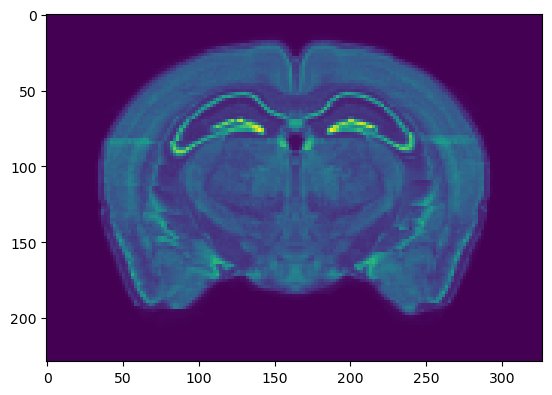

The compare_version function is deprecated. Use is_version_at_least instead.


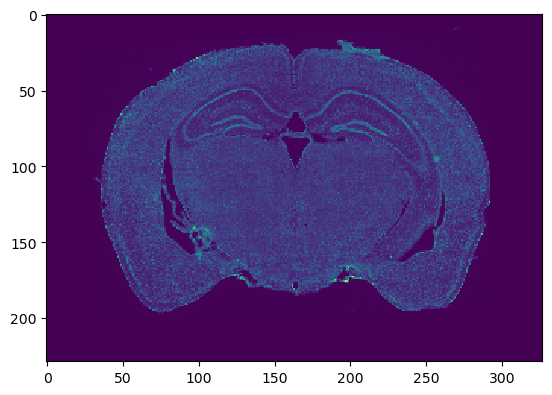

0
1
2


The compare_version function is deprecated. Use is_version_at_least instead.
The compare_version function is deprecated. Use is_version_at_least instead.


3
4
4a
4b
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
5
5a
5b
6
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
6a
7


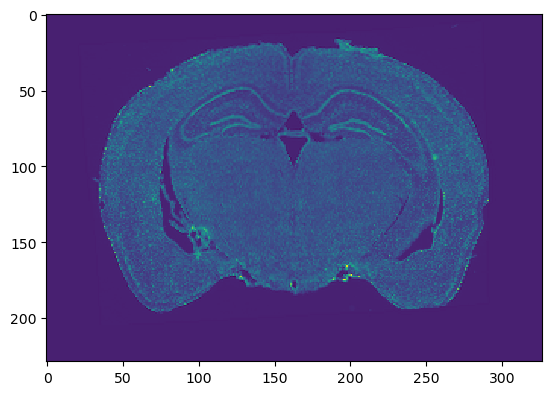

8


[java.lang.Enum.toString] 17:32:56.912 [ForkJoinPool.commonPool-worker-1] DEBUG ch.epfl.biop.atlas.aligner.SliceSources - S40.tif-ch0: action ch.epfl.biop.atlas.aligner.plugin.SimpleRegistrationWrapper@748c94a8 [M].[Ch[0]].Atlas // [M].[Ch[0]].Section)] (pending) result true
[java.lang.Enum.toString] 17:32:56.916 [ForkJoinPool.commonPool-worker-1] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Task removed. Current number of tasks: 0


Settings inputs...
{moving_channel=0, mp=ch.epfl.biop.atlas.aligner.MultiSlicePositioner@2a7895aa, fixed_channel=0}
Inputs set.
Running scijava command: abba.SimpleRotateAffineRegistration
init SimpleRotateAffineRegistration
init SimpleRotateAffineRegistration
abba.SimpleRotateAffineRegistration command execution done.
Fetching outputs...
Outputs set.


[java.lang.Enum.toString] 17:33:16.226 [SciJava-6e106680-Thread-3] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - External registration found: SimpleRotateAffineRegistration
[java.lang.Enum.toString] 17:33:16.226 [SciJava-6e106680-Thread-3] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Putting user defined ROIs
[java.lang.Enum.toString] 17:33:16.226 [SciJava-6e106680-Thread-3] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Starting slice registration for S40.tif-ch0
[java.lang.Enum.toString] 17:33:16.226 [SciJava-6e106680-Thread-3] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - 	 slice registration for S40.tif-ch0- set context
[java.lang.Enum.toString] 17:33:16.226 [SciJava-6e106680-Thread-3] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - 	 slice registration for S40.tif-ch0- setSliceInfo
[java.lang.Enum.toString] 17:33:16.226 [SciJava-6e106680-Thread-3] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - 	 slice registration for S40.ti

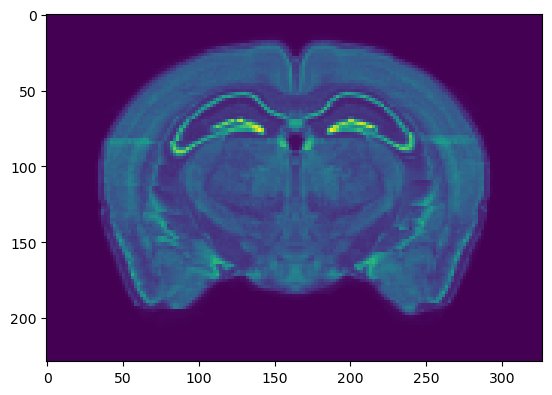

The compare_version function is deprecated. Use is_version_at_least instead.


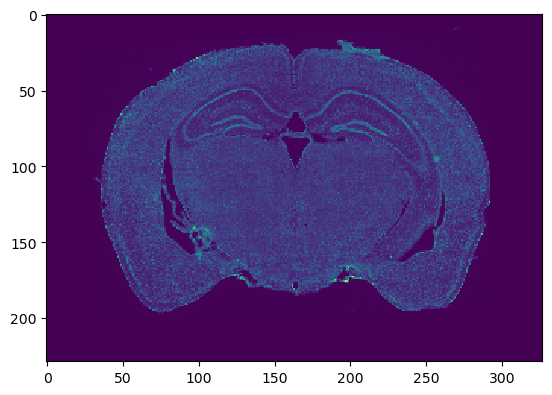

The compare_version function is deprecated. Use is_version_at_least instead.
The compare_version function is deprecated. Use is_version_at_least instead.


0
1
2
3
4
4a
4b
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
5
5a
5b
6
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
6a
7


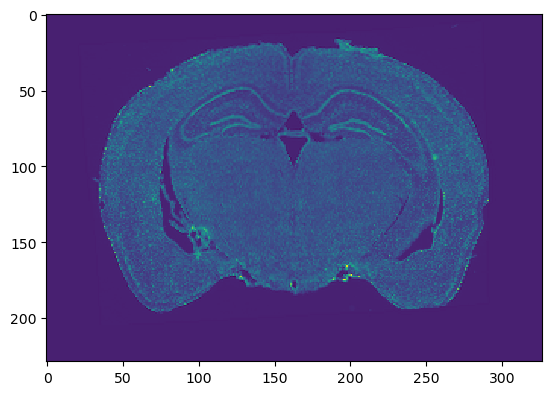

8


[java.lang.Enum.toString] 17:33:18.916 [ForkJoinPool.commonPool-worker-2] DEBUG ch.epfl.biop.atlas.aligner.SliceSources - S40.tif-ch0: action ch.epfl.biop.atlas.aligner.plugin.SimpleRegistrationWrapper@7f9b79e8 [M].[Ch[0]].Atlas // [M].[Ch[0]].Section)] (pending) result true
[java.lang.Enum.toString] 17:33:18.921 [ForkJoinPool.commonPool-worker-2] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Task removed. Current number of tasks: 0
[java.lang.Enum.toString] 17:33:24.746 [AWT-EventQueue-0] DEBUG ch.epfl.biop.bdv.gui.graphicalhandle.GraphicalHandle - Installing ch.epfl.biop.atlas.aligner.gui.bdv.SliceGuiState@5a19cff2_keyHandle from ch.epfl.biop.bdv.gui.graphicalhandle.SquareGraphicalHandle@240d5c8a (x = 473 and y = 257)
[java.lang.Enum.toString] 17:33:27.619 [AWT-EventQueue-0] DEBUG ch.epfl.biop.bdv.gui.graphicalhandle.GraphicalHandle - Removing ch.epfl.biop.atlas.aligner.gui.bdv.SliceGuiState@5a19cff2_keyHandle from ch.epfl.biop.bdv.gui.graphicalhandle.SquareGraphicalHandle@

[java.lang.Enum.toString] 17:33:36.042 [AWT-EventQueue-0] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Action ch.epfl.biop.atlas.aligner.DeleteLastRegistrationAction@4301108f on slice S40.tif-ch0 requested (async).
[java.lang.Enum.toString] 17:33:36.048 [AWT-EventQueue-0] DEBUG ch.epfl.biop.atlas.aligner.SliceActionObserver - Action registered in observer: ch.epfl.biop.atlas.aligner.DeleteLastRegistrationAction@4301108f
[java.lang.Enum.toString] 17:33:36.049 [AWT-EventQueue-0] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Action ch.epfl.biop.atlas.aligner.DeleteLastRegistrationAction@4301108f on slice S40.tif-ch0 is valid.
[java.lang.Enum.toString] 17:33:36.050 [AWT-EventQueue-0] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Action ch.epfl.biop.atlas.aligner.DeleteLastRegistrationAction@4301108f on slice S40.tif-ch0 added to userActions.
[java.lang.Enum.toString] 17:33:36.049 [ForkJoinPool.commonPool-worker-7] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePo

[java.lang.Enum.toString] 17:33:47.307 [AWT-EventQueue-0] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Stopping a drag action
[java.lang.Enum.toString] 17:33:47.307 [AWT-EventQueue-0] DEBUG ch.epfl.biop.atlas.aligner.gui.bdv.SelectionLayer - Selection drag stopped.
[java.lang.Enum.toString] 17:33:50.394 [AWT-EventQueue-0] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Action ch.epfl.biop.atlas.aligner.DeleteLastRegistrationAction@470aa511 on slice S40.tif-ch0 requested (async).
[java.lang.Enum.toString] 17:33:50.400 [AWT-EventQueue-0] DEBUG ch.epfl.biop.atlas.aligner.SliceActionObserver - Action registered in observer: ch.epfl.biop.atlas.aligner.DeleteLastRegistrationAction@470aa511
[java.lang.Enum.toString] 17:33:50.401 [AWT-EventQueue-0] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Action ch.epfl.biop.atlas.aligner.DeleteLastRegistrationAction@470aa511 on slice S40.tif-ch0 is valid.
[java.lang.Enum.toString] 17:33:50.402 [AWT-EventQueue-0] DEBUG ch.epfl

Settings inputs...
{moving_channel=0, mp=ch.epfl.biop.atlas.aligner.MultiSlicePositioner@2a7895aa, fixed_channel=0}
Inputs set.
Running scijava command: abba.SimpleRotateAffineRegistration
init SimpleRotateAffineRegistration
init SimpleRotateAffineRegistration
abba.SimpleRotateAffineRegistration command execution done.
Fetching outputs...
Outputs set.


[java.lang.Enum.toString] 17:34:00.332 [AWT-EventQueue-0] WARN ch.epfl.biop.atlas.aligner.adapter.AlignerState - Error : issue with filtering serializable actions


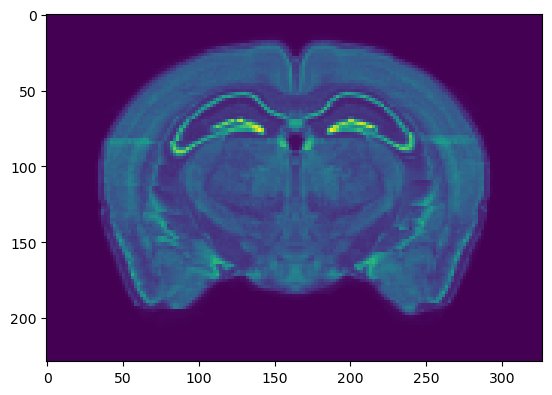

The compare_version function is deprecated. Use is_version_at_least instead.


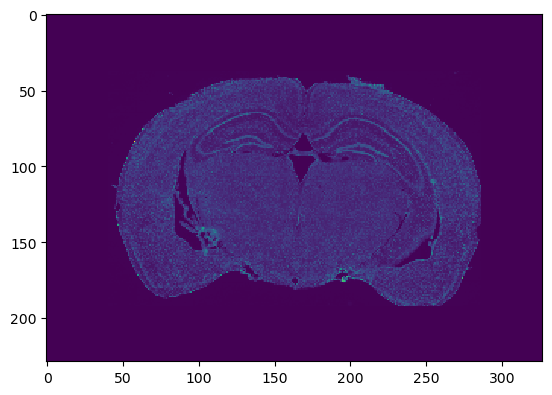

The compare_version function is deprecated. Use is_version_at_least instead.
The compare_version function is deprecated. Use is_version_at_least instead.


0
1
2
3
4
4a
4b
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
5
5a
5b
6
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
6a


[java.lang.Enum.toString] 17:34:00.836 [AWT-EventQueue-0] WARN ch.epfl.biop.atlas.aligner.adapter.AlignerState - Error : issue with filtering serializable actions


7


[java.lang.Enum.toString] 17:34:01.736 [AWT-EventQueue-0] WARN ch.epfl.biop.atlas.aligner.adapter.AlignerState - Error : issue with filtering serializable actions


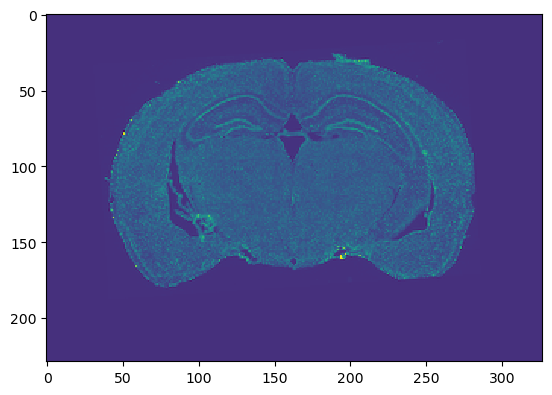

[java.lang.Enum.toString] 17:34:01.856 [AWT-EventQueue-0] WARN ch.epfl.biop.atlas.aligner.adapter.AlignerState - Error : issue with filtering serializable actions
[java.lang.Enum.toString] 17:34:01.861 [ForkJoinPool.commonPool-worker-0] DEBUG ch.epfl.biop.atlas.aligner.SliceSources - S40.tif-ch0: action ch.epfl.biop.atlas.aligner.plugin.SimpleRegistrationWrapper@795c50e [M].[Ch[0]].Atlas // [M].[Ch[0]].Section)] (pending) result true
[java.lang.Enum.toString] 17:34:01.861 [ForkJoinPool.commonPool-worker-0] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Task removed. Current number of tasks: 0
[java.lang.Enum.toString] 17:34:01.866 [AWT-EventQueue-0] WARN ch.epfl.biop.atlas.aligner.adapter.AlignerState - Error : issue with filtering serializable actions
[java.lang.Enum.toString] 17:34:01.876 [AWT-EventQueue-0] WARN ch.epfl.biop.atlas.aligner.adapter.AlignerState - Error : issue with filtering serializable actions
[java.lang.Enum.toString] 17:34:01.898 [AWT-EventQueue-0] WARN ch

8


[java.lang.Enum.toString] 17:34:01.976 [AWT-EventQueue-0] WARN ch.epfl.biop.atlas.aligner.adapter.AlignerState - Error : issue with filtering serializable actions
[java.lang.Enum.toString] 17:34:02.086 [AWT-EventQueue-0] WARN ch.epfl.biop.atlas.aligner.adapter.AlignerState - Error : issue with filtering serializable actions
[java.lang.Enum.toString] 17:34:02.346 [AWT-EventQueue-0] WARN ch.epfl.biop.atlas.aligner.adapter.AlignerState - Error : issue with filtering serializable actions
[java.lang.Enum.toString] 17:34:05.506 [AWT-EventQueue-0] WARN ch.epfl.biop.atlas.aligner.adapter.AlignerState - Error : issue with filtering serializable actions
[java.lang.Enum.toString] 17:34:05.516 [AWT-EventQueue-0] WARN ch.epfl.biop.atlas.aligner.adapter.AlignerState - Error : issue with filtering serializable actions
[java.lang.Enum.toString] 17:34:05.546 [AWT-EventQueue-0] WARN ch.epfl.biop.atlas.aligner.adapter.AlignerState - Error : issue with filtering serializable actions
[java.lang.Enum.toStri

Settings inputs...
{moving_channel=0, mp=ch.epfl.biop.atlas.aligner.MultiSlicePositioner@2a7895aa, fixed_channel=0}
Inputs set.
Running scijava command: abba.SimpleRotateAffineRegistration
init SimpleRotateAffineRegistration
init SimpleRotateAffineRegistration
abba.SimpleRotateAffineRegistration command execution done.
Fetching outputs...
Outputs set.


[java.lang.Enum.toString] 17:34:12.296 [AWT-EventQueue-0] WARN ch.epfl.biop.atlas.aligner.adapter.AlignerState - Error : issue with filtering serializable actions


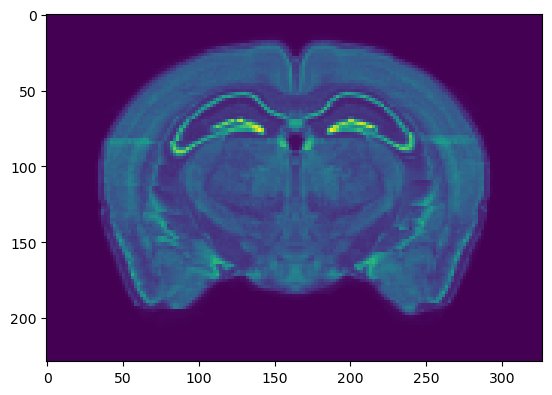

The compare_version function is deprecated. Use is_version_at_least instead.


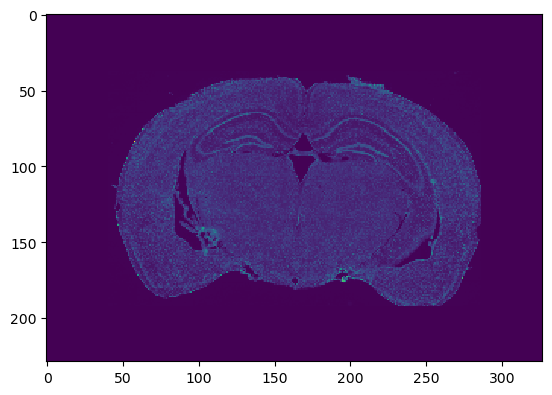

The compare_version function is deprecated. Use is_version_at_least instead.
The compare_version function is deprecated. Use is_version_at_least instead.


0
1
2
3
4
4a
4b
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
5
5a
5b
6
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
6a


[java.lang.Enum.toString] 17:34:12.810 [AWT-EventQueue-0] WARN ch.epfl.biop.atlas.aligner.adapter.AlignerState - Error : issue with filtering serializable actions


7


[java.lang.Enum.toString] 17:34:13.786 [AWT-EventQueue-0] WARN ch.epfl.biop.atlas.aligner.adapter.AlignerState - Error : issue with filtering serializable actions
[java.lang.Enum.toString] 17:34:13.826 [AWT-EventQueue-0] WARN ch.epfl.biop.atlas.aligner.adapter.AlignerState - Error : issue with filtering serializable actions


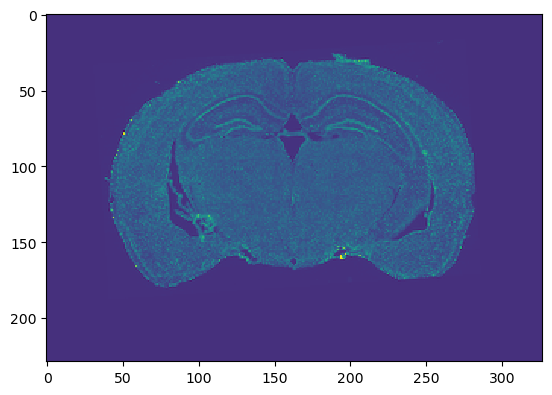

[java.lang.Enum.toString] 17:34:13.911 [AWT-EventQueue-0] WARN ch.epfl.biop.atlas.aligner.adapter.AlignerState - Error : issue with filtering serializable actions
[java.lang.Enum.toString] 17:34:13.916 [ForkJoinPool.commonPool-worker-3] DEBUG ch.epfl.biop.atlas.aligner.SliceSources - S40.tif-ch0: action ch.epfl.biop.atlas.aligner.plugin.SimpleRegistrationWrapper@2875ee8c [M].[Ch[0]].Atlas // [M].[Ch[0]].Section)] (pending) result true
[java.lang.Enum.toString] 17:34:13.916 [ForkJoinPool.commonPool-worker-3] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Task removed. Current number of tasks: 0
[java.lang.Enum.toString] 17:34:13.926 [AWT-EventQueue-0] WARN ch.epfl.biop.atlas.aligner.adapter.AlignerState - Error : issue with filtering serializable actions
[java.lang.Enum.toString] 17:34:13.941 [AWT-EventQueue-0] WARN ch.epfl.biop.atlas.aligner.adapter.AlignerState - Error : issue with filtering serializable actions
[java.lang.Enum.toString] 17:34:13.996 [AWT-EventQueue-0] WARN c

8


[java.lang.Enum.toString] 17:34:14.126 [AWT-EventQueue-0] WARN ch.epfl.biop.atlas.aligner.adapter.AlignerState - Error : issue with filtering serializable actions
[java.lang.Enum.toString] 17:34:14.346 [AWT-EventQueue-0] WARN ch.epfl.biop.atlas.aligner.adapter.AlignerState - Error : issue with filtering serializable actions
[java.lang.Enum.toString] 17:34:14.376 [AWT-EventQueue-0] WARN ch.epfl.biop.atlas.aligner.adapter.AlignerState - Error : issue with filtering serializable actions
[java.lang.Enum.toString] 17:34:18.386 [AWT-EventQueue-0] WARN ch.epfl.biop.atlas.aligner.adapter.AlignerState - Error : issue with filtering serializable actions
[java.lang.Enum.toString] 17:34:20.178 [AWT-EventQueue-0] WARN ch.epfl.biop.atlas.aligner.adapter.AlignerState - Error : issue with filtering serializable actions
[java.lang.Enum.toString] 17:34:35.251 [SciJava-6e106680-Thread-40] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - External registration found: SimpleRotateAffineRegistration
[

Settings inputs...
{moving_channel=0, mp=ch.epfl.biop.atlas.aligner.MultiSlicePositioner@2a7895aa, fixed_channel=1}
Inputs set.
Running scijava command: abba.SimpleRotateAffineRegistration
init SimpleRotateAffineRegistration
init SimpleRotateAffineRegistration
abba.SimpleRotateAffineRegistration command execution done.
Fetching outputs...
Outputs set.


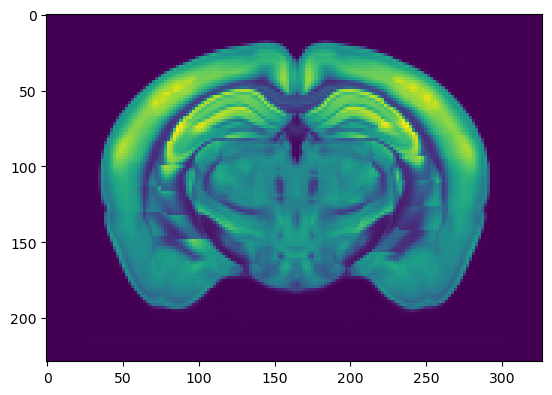

The compare_version function is deprecated. Use is_version_at_least instead.


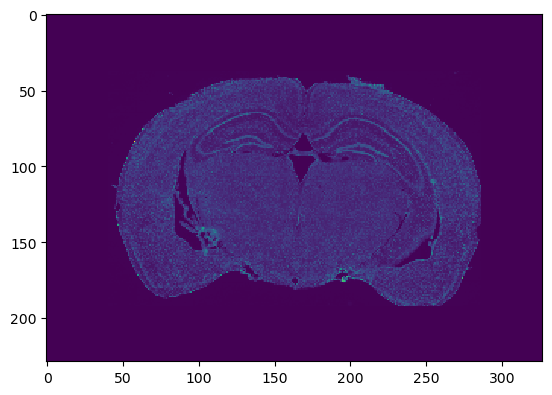

The compare_version function is deprecated. Use is_version_at_least instead.
The compare_version function is deprecated. Use is_version_at_least instead.


0
1
2
3
4
4a
4b
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
5
5a
5b
6
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
6a


[java.lang.Enum.toString] 17:34:35.856 [AWT-EventQueue-0] WARN ch.epfl.biop.atlas.aligner.adapter.AlignerState - Error : issue with filtering serializable actions


7


[java.lang.Enum.toString] 17:34:36.746 [AWT-EventQueue-0] WARN ch.epfl.biop.atlas.aligner.adapter.AlignerState - Error : issue with filtering serializable actions


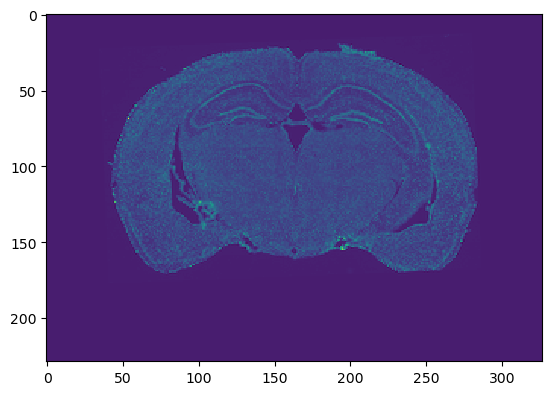

[java.lang.Enum.toString] 17:34:36.856 [AWT-EventQueue-0] WARN ch.epfl.biop.atlas.aligner.adapter.AlignerState - Error : issue with filtering serializable actions
[java.lang.Enum.toString] 17:34:36.866 [ForkJoinPool.commonPool-worker-5] DEBUG ch.epfl.biop.atlas.aligner.SliceSources - S40.tif-ch0: action ch.epfl.biop.atlas.aligner.plugin.SimpleRegistrationWrapper@4d945875 [M].[Ch[1]].Atlas // [M].[Ch[0]].Section)] (pending) result true
[java.lang.Enum.toString] 17:34:36.866 [ForkJoinPool.commonPool-worker-5] DEBUG ch.epfl.biop.atlas.aligner.MultiSlicePositioner - Task removed. Current number of tasks: 0
[java.lang.Enum.toString] 17:34:36.876 [AWT-EventQueue-0] WARN ch.epfl.biop.atlas.aligner.adapter.AlignerState - Error : issue with filtering serializable actions
[java.lang.Enum.toString] 17:34:36.893 [AWT-EventQueue-0] WARN ch.epfl.biop.atlas.aligner.adapter.AlignerState - Error : issue with filtering serializable actions
[java.lang.Enum.toString] 17:34:36.906 [AWT-EventQueue-0] WARN c

8


[java.lang.Enum.toString] 17:34:36.976 [AWT-EventQueue-0] WARN ch.epfl.biop.atlas.aligner.adapter.AlignerState - Error : issue with filtering serializable actions
[java.lang.Enum.toString] 17:34:37.116 [AWT-EventQueue-0] WARN ch.epfl.biop.atlas.aligner.adapter.AlignerState - Error : issue with filtering serializable actions
[java.lang.Enum.toString] 17:34:37.366 [AWT-EventQueue-0] WARN ch.epfl.biop.atlas.aligner.adapter.AlignerState - Error : issue with filtering serializable actions


In [8]:
SourcesChannelsSelect = jimport('ch.epfl.biop.sourceandconverter.processor.SourcesChannelsSelect')
HashMap = jimport('java.util.HashMap')


@ScijavaCommand(context = ij.context(), # ij context needed
                name = 'abba.SimpleRotateAffineRegistration', # name of this command, mind potential naming conflicts!
                inputs = {'fixed_channel': JInt, 'moving_channel': JInt, 'mp': MultiSlicePositioner}, # input name, input Java class, as dictionary
                outputs = {}) # output name, output Java class, as dictionary
class SimpleRotateAffineRegistrationCommand:        
    def run(self):
        params = HashMap()
        self.mp.registerSelectedSlices('SimpleRotateAffineRegistration',
                            SourcesChannelsSelect(self.fixed_channel),
                            SourcesChannelsSelect(self.moving_channel),
                            params)
            
MultiSlicePositioner.registerRegistrationPluginUI('SimpleRotateAffineRegistration', 'abba.SimpleRotateAffineRegistration');

In [ ]:
parameter_object = itk.ParameterObject.New()
default_rigid_parameter_map = parameter_object.GetDefaultParameterMap('rigid')
parameter_object.AddParameterMap(default_rigid_parameter_map)

In [ ]:
# Call registration function
result_image, result_transform_parameters = itk.elastix_registration_method(
    fixed_image, moving_image,
    parameter_object=parameter_object,
    log_to_console=True)

In [ ]:
ij.py.show(fixed_py)

In [ ]:
ij.py.show(moving_py)

In [ ]:
import numpy as np
fixed = np.asarray(fixed_py).astype(np.float32)
type(fixed)
moving = np.asarray(moving_py).astype(np.float32)
type(moving)

In [ ]:
# Register!
registered, parameters = itk.elastix_registration_method(fixed, moving)
type(registered)

In [ ]:
ij.py.show(registered)

In [9]:
parameter_object = itk.ParameterObject.New()
default_rigid_parameter_map = parameter_object.GetDefaultParameterMap('rigid')
parameter_object.AddParameterMap(default_rigid_parameter_map)

In [10]:


# Call registration function
result_image, result_transform_parameters = itk.elastix_registration_method(
    fixed_py, moving_py,
    parameter_object=parameter_object,
    log_to_console=False)



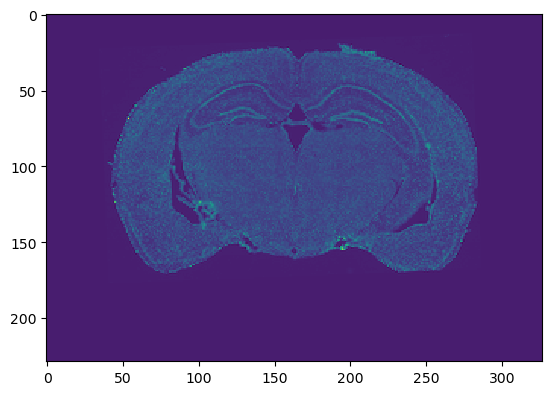

In [11]:
ij.py.show(result_image)

In [12]:
print(result_transform_parameters)

ParameterObject (00000264586232D0)
  RTTI typeinfo:   class elastix::ParameterObject
  Reference Count: 1
  Modified Time: 206001
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 163 114)
  (CompressResultImage "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 2)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 2)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 3)
  (Origin 0 0)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 327 229)
  (Spacing 1 1)
  (Transform "EulerTransform")
  (TransformParameters 0.0409453 2.18843 19.8089)
  (UseDirectionCosines "true")



In [34]:
print(result_transform_parameters.GetParameter(0, "CompressResultImage"))


('false',)


In [35]:
print(result_transform_parameters.GetParameter(0, "ResampleInterpolator"))

('FinalBSplineInterpolator',)


In [40]:
len(result_transform_parameters.GetParameter(0, "ResampleInterpolator"))

1

In [4]:
a = input()
print(a)

hellonico
nico
